##### Copyright 2024 Google LLC.

In [ ]:
# @title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Day 2 - Document Q&A with RAG using Chroma

Welcome back to the Kaggle 5-day Generative AI course!

**NOTE**: The Day 1 notebook contains lots of information for getting set up with Kaggle Notebooks. If you are having any issues, please [check out the troubleshooting steps there](https://www.kaggle.com/code/markishere/day-1-prompting#Get-started-with-Kaggle-notebooks).

Two big limitations of LLMs are 1) that they only "know" the information that they were trained on, and 2) that they have limited input context windows. A way to address both of these limitations is to use a technique called Retrieval Augmented Generation, or RAG. A RAG system has three stages:

1. Indexing
2. Retrieval
3. Generation

Indexing happens ahead of time, and allows you to quickly look up relevant information at query-time. When a query comes in, you retrieve relevant documents, combine them with your instructions and the user's query, and have the LLM generate a tailored answer in natural language using the supplied information. This allows you to provide information that the model hasn't seen before, such as product-specific knowledge or live weather updates.

In this notebook you will use the Gemini API to create a vector database, retrieve answers to questions from the database and generate a final answer. You will use [Chroma](https://docs.trychroma.com/), an open-source vector database. With Chroma, you can store embeddings alongside metadata, embed documents and queries, and search your documents.

## For help

**Common issues are covered in the [FAQ and troubleshooting guide](https://www.kaggle.com/code/markishere/day-0-troubleshooting-and-faqs).**


## Setup

First, install ChromaDB and the Gemini API Python SDK.

In [ ]:
%pip install -U -q "google-generativeai>=0.8.3" chromadb

You may see output containing `ERROR: pip's dependency resolver does not currently take into account all the packages that are installed` - this is OK, the packages are still installed and compatible for this codelab. Also note that you do not have to restart the kernel.

In [ ]:
import google.generativeai as genai
from IPython.display import Markdown

### Set up your API key

To run the following cell, your API key must be stored it in a [Kaggle secret](https://www.kaggle.com/discussions/product-feedback/114053) named `GOOGLE_API_KEY`.

If you don't already have an API key, you can grab one from [AI Studio](https://aistudio.google.com/app/apikey). You can find [detailed instructions in the docs](https://ai.google.dev/gemini-api/docs/api-key).

To make the key available through Kaggle secrets, choose `Secrets` from the `Add-ons` menu and follow the instructions to add your key or enable it for this notebook.

In [ ]:
from kaggle_secrets import UserSecretsClient

GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
genai.configure(api_key=GOOGLE_API_KEY)

If you received an error response along the lines of `No user secrets exist for kernel id ...`, then you need to add your API key via `Add-ons`, `Secrets` **and** enable it.

![Screenshot of the checkbox to enable GOOGLE_API_KEY secret](https://storage.googleapis.com/kaggle-media/Images/5gdai_sc_3.png)
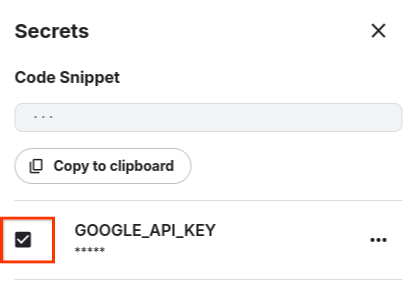

### Explore available models

You will be using the [`embedContent`](https://ai.google.dev/api/embeddings#method:-models.embedcontent) API method to calculate embeddings in this guide. Find a model that supports it through the [`models.list`](https://ai.google.dev/api/models#method:-models.list) endpoint. You can also find more information about the embedding models on [the models page](https://ai.google.dev/gemini-api/docs/models/gemini#text-embedding).

`text-embedding-004` is the most recent embedding model, so you will use it for this exercise.

In [ ]:
for m in genai.list_models():
    if "embedContent" in m.supported_generation_methods:
        print(m.name)

### Data

Here is a small set of documents you will use to create an embedding database.

In [ ]:
DOCUMENT1 = "Operating the Climate Control System  Your Googlecar has a climate control system that allows you to adjust the temperature and airflow in the car. To operate the climate control system, use the buttons and knobs located on the center console.  Temperature: The temperature knob controls the temperature inside the car. Turn the knob clockwise to increase the temperature or counterclockwise to decrease the temperature. Airflow: The airflow knob controls the amount of airflow inside the car. Turn the knob clockwise to increase the airflow or counterclockwise to decrease the airflow. Fan speed: The fan speed knob controls the speed of the fan. Turn the knob clockwise to increase the fan speed or counterclockwise to decrease the fan speed. Mode: The mode button allows you to select the desired mode. The available modes are: Auto: The car will automatically adjust the temperature and airflow to maintain a comfortable level. Cool: The car will blow cool air into the car. Heat: The car will blow warm air into the car. Defrost: The car will blow warm air onto the windshield to defrost it."
DOCUMENT2 = 'Your Googlecar has a large touchscreen display that provides access to a variety of features, including navigation, entertainment, and climate control. To use the touchscreen display, simply touch the desired icon.  For example, you can touch the "Navigation" icon to get directions to your destination or touch the "Music" icon to play your favorite songs.'
DOCUMENT3 = "Shifting Gears Your Googlecar has an automatic transmission. To shift gears, simply move the shift lever to the desired position.  Park: This position is used when you are parked. The wheels are locked and the car cannot move. Reverse: This position is used to back up. Neutral: This position is used when you are stopped at a light or in traffic. The car is not in gear and will not move unless you press the gas pedal. Drive: This position is used to drive forward. Low: This position is used for driving in snow or other slippery conditions."

documents = [DOCUMENT1, DOCUMENT2, DOCUMENT3]

## Creating the embedding database with ChromaDB

Create a [custom function](https://docs.trychroma.com/guides/embeddings#custom-embedding-functions) to generate embeddings with the Gemini API. In this task, you are implementing a retrieval system, so the `task_type` for generating the *document* embeddings is `retrieval_document`. Later, you will use `retrieval_query` for the *query* embeddings. Check out the [API reference](https://ai.google.dev/api/embeddings#v1beta.TaskType) for the full list of supported tasks.


In [ ]:
from chromadb import Documents, EmbeddingFunction, Embeddings
from google.api_core import retry


class GeminiEmbeddingFunction(EmbeddingFunction):
    # Specify whether to generate embeddings for documents, or queries
    document_mode = True

    def __call__(self, input: Documents) -> Embeddings:
        if self.document_mode:
            embedding_task = "retrieval_document"
        else:
            embedding_task = "retrieval_query"

        retry_policy = {"retry": retry.Retry(predicate=retry.if_transient_error)}

        response = genai.embed_content(
            model="models/text-embedding-004",
            content=input,
            task_type=embedding_task,
            request_options=retry_policy,
        )
        return response["embedding"]

Now create a [Chroma database client](https://docs.trychroma.com/getting-started) that uses the `GeminiEmbeddingFunction` and populate the database with the documents you defined above.

In [ ]:
import chromadb

DB_NAME = "googlecardb"
embed_fn = GeminiEmbeddingFunction()
embed_fn.document_mode = True

chroma_client = chromadb.Client()
db = chroma_client.get_or_create_collection(name=DB_NAME, embedding_function=embed_fn)

db.add(documents=documents, ids=[str(i) for i in range(len(documents))])

Confirm that the data was inserted by looking at the database.

In [ ]:
db.count()
# You can peek at the data too.
# db.peek(1)

## Retrieval: Find relevant documents

To search the Chroma database, call the `query` method. Note that you also switch to the `retrieval_query` mode of embedding generation.


In [ ]:
# Switch to query mode when generating embeddings.
embed_fn.document_mode = False

# Search the Chroma DB using the specified query.
query = "How do you use the touchscreen to play music?"

result = db.query(query_texts=[query], n_results=1)
[[passage]] = result["documents"]

Markdown(passage)

## Augmented generation: Answer the question

Now that you have found a relevant passage from the set of documents (the *retrieval* step), you can now assemble a generation prompt to have the Gemini API *generate* a final answer. Note that in this example only a single passage was retrieved. In practice, especially when the size of your underlying data is large, you will want to retrieve more than one result and let the Gemini model determine what passages are relevant in answering the question. For this reason it's OK if some retrieved passages are not directly related to the question - this generation step should ignore them.

In [ ]:
passage_oneline = passage.replace("\n", " ")
query_oneline = query.replace("\n", " ")

# This prompt is where you can specify any guidance on tone, or what topics the model should stick to, or avoid.
prompt = f"""You are a helpful and informative bot that answers questions using text from the reference passage included below. 
Be sure to respond in a complete sentence, being comprehensive, including all relevant background information. 
However, you are talking to a non-technical audience, so be sure to break down complicated concepts and 
strike a friendly and converstional tone. If the passage is irrelevant to the answer, you may ignore it.

QUESTION: {query_oneline}
PASSAGE: {passage_oneline}
"""
print(prompt)

Now use the `generate_content` method to to generate an answer to the question.

In [ ]:
model = genai.GenerativeModel("gemini-1.5-flash-latest")
answer = model.generate_content(prompt)
Markdown(answer.text)

## Next steps

Congrats on building a Retrieval-Augmented Generation app!

To learn more about using embeddings in the Gemini API, check out the [Intro to embeddings](https://ai.google.dev/gemini-api/docs/embeddings) or to learn more fundamentals, study the [embeddings chapter](https://developers.google.com/machine-learning/crash-course/embeddings) of the Machine Learning Crash Course.

For a hosted RAG system, check out the [Semantic Retrieval service](https://ai.google.dev/gemini-api/docs/semantic_retrieval) in the Gemini API. You can implement question-answering on your own documents in a single request, or host a database for even faster responses.